<a href="https://colab.research.google.com/github/GoogleCloudPlatform/tensorflow-without-a-phd/blob/master/tensorflow-rnn-tutorial/02_Keras_RNN_TPU_temperatures_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An RNN model for temperature data
This time we will be working with real data: daily (Tmin, Tmax) temperature series from 1666 weather stations spanning 50 years. It is to be noted that a pretty good predictor model already exists for temperatures: the average of temperatures on the same day of the year in N previous years. It is not clear if RNNs can do better but we will se how far they can go.

In [1]:
import os, re, math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import transforms as plttrans
import tensorflow as tf
#tf.enable_eager_execution()  # this does not yet work with TPUs
print("Tensorflow version: " + tf.__version__)

MAX_DATE = 18262 # 50 years of data, Tmin, Tmax each day

Tensorflow version: 1.13.1


In [0]:
#@title Data formatting and display utilites [RUN ME]

# Training data sequencer: this version works from TFRecords and uses tf.data.Dataset
def rnn_dataset_sequencer3tfrec(filenames, resample_by=1, batch_size=9999, seqlen=MAX_DATE, n_forward=0, nb_epochs=1, tminmax_only=False, drop_remainder=False, ordered=False):
  # drop_remainder applies to batch size only,
  # the remainders introduced by "resample_by" and "seqlen" are always dropped
  
  def truncate(x, n):
    return x[:x.get_shape()[0] // n * n]
  
  def read_tfrecord(example):
      feature = {
        "date": tf.io.FixedLenFeature([MAX_DATE], tf.string),
        "tmin": tf.io.FixedLenFeature([MAX_DATE], tf.float32),
        "tmax": tf.io.FixedLenFeature([MAX_DATE], tf.float32),
        "interpolated": tf.io.FixedLenFeature([MAX_DATE], tf.int64)
      }
      example = tf.io.parse_single_example(example, feature)
      temps = tf.stack([example['tmin'], example['tmax']], axis=1)
      return temps, example['date'], example['interpolated']

  def truncate(x, n):
    return x[:x.get_shape()[0] // n * n]
  
  def process_metadata(x, mean=False):
    x = truncate(x, resample_by)
    x = tf.reshape(x, [-1, resample_by])
    if mean:
      x = tf.math.greater(tf.reduce_mean(tf.cast(x, tf.float32), axis=1), 0.0)
    else:
      x = x[:,0]
    x = x[:x.get_shape()[0]-n_forward] # allows n_forward=0
    x = truncate(x, seqlen)
    x = tf.reshape(x, [-1, seqlen])
    return x
  
  def process_data(temps, dates, interpolated):
    temps = truncate(temps, resample_by)
    temps = tf.reduce_mean(tf.reshape(temps, [-1, resample_by, 2]), axis=1)
    temps, targets = temps[:temps.get_shape()[0]-n_forward], temps[n_forward:] # allows n_forward=0
    temps, targets = truncate(temps, seqlen), truncate(targets, seqlen)
    temps, targets = tf.reshape(temps, [-1, seqlen, 2]), tf.reshape(targets, [-1, seqlen, 2])
    return temps, targets, process_metadata(dates), process_metadata(interpolated, mean=True)
  
  dataset = tf.data.TFRecordDataset(filenames, "GZIP", num_parallel_reads=1 if ordered else 16) # 16 or 32 same perf
  dataset = dataset.map(read_tfrecord, num_parallel_calls=32)
  dataset = dataset.apply(tf.data.experimental.map_and_batch(process_data, batch_size, drop_remainder=drop_remainder))
  dataset = dataset.map(lambda x, y, z, t: (tf.transpose(x, [1, 0, 2, 3]), tf.transpose(y, [1, 0, 2, 3]),  tf.transpose(z, [1, 0, 2]),  tf.transpose(t, [1, 0, 2])))
  dataset = dataset.apply(tf.data.experimental.unbatch())
  
  if tminmax_only:
    dataset = dataset.map(lambda temps, targets, date, interp: (temps, targets))
    
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  dataset = dataset.cache()
  dataset = dataset.repeat(nb_epochs)
  return dataset


# override default matplotlib styles
plt.rcParams['figure.figsize']=(16.8,6.0)
plt.rcParams['axes.grid']=True
plt.rcParams['axes.linewidth']=0
plt.rcParams['grid.color']='#DDDDDD'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['xtick.major.size']=0
plt.rcParams['ytick.major.size']=0
plt.rcParams['axes.titlesize']=15.0

def display_lr(lr_schedule, nb_epochs):
  x = np.arange(nb_epochs)
  y = [lr_schedule(i) for i in x]
  plt.figure(figsize=(9,5))
  plt.step(x,y, where='post')
  plt.title("Learning rate schedule\nmax={:.2e}, min={:.2e}".format(np.max(y), np.min(y)),
            y=0.85)
  plt.xlabel('EPOCH')
  plt.show()
  
def display_loss(history, full_history, nb_epochs):
  plt.figure()
  plt.plot(np.arange(0, len(full_history['loss']))/steps_per_epoch, full_history['loss'], label='detailed loss')
  plt.plot(np.arange(1, nb_epochs+1), history['loss'], color='red', linewidth=3, label='average loss per epoch')
  plt.ylim(0,3*max(history['loss'][1:]))
  plt.xlabel('EPOCH')
  plt.ylabel('LOSS')
  plt.xlim(0, nb_epochs+0.5)
  plt.legend()
  for epoch in range(nb_epochs//2+1):
    plt.gca().axvspan(2*epoch, 2*epoch+1, alpha=0.05, color='grey')
  plt.show()


def dataset_to_numpy(dataset, batches=1):
  data = []
  
  # In eager mode, iterate on the Datset directly.
  if tf.executing_eagerly():
    for i, data_batch in zip(range(batches), dataset): # will stop on shortest
      data.append(data_batch)

  # In non-eager mode, must get the TF node that
  # yields the next item and run it in a tf.Session.
  else:
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      for _ in range(batches):
        data.append(ses.run(get_next_item))
      
  # parse dates
  data = [(samples,
           targets,
           np.array(dates, dtype='datetime64'),
           interpolated)
          for samples, targets, dates, interpolated in data]

  return data

        
def picture_this_4(temperatures, dates, interpolated):
  min_temps = temperatures[:,0]
  max_temps = temperatures[:,1]
  #interpolated = temperatures[:,2]

  interpolated_sequence = False
  #plt.plot(dates, max_temps)
  for i, date in enumerate(dates):
    if interpolated[i]:
      if not interpolated_sequence:
        startdate = date
      interpolated_sequence = True
      stopdate = date
    else:
      if interpolated_sequence:
        # light shade of red just for visibility
        plt.axvspan(startdate+np.timedelta64(-5, 'D'), stopdate+np.timedelta64(6, 'D'), facecolor='#FFCCCC', alpha=1)
        # actual interpolated region
        plt.axvspan(startdate+np.timedelta64(-1, 'D'), stopdate+np.timedelta64(1, 'D'), facecolor='#FF8888', alpha=1)
      interpolated_sequence = False
  plt.fill_between(dates, min_temps, max_temps).set_zorder(10)
  plt.show()
  
def picture_this_5(visu_data, station):
  subplot = 231
  for samples, targets, dates, _ in visu_data:
    plt.subplot(subplot)
    h1 = plt.fill_between(dates[station], samples[station,:,0], samples[station,:,1], label="features")
    h2 = plt.fill_between(dates[station], targets[station,:,0], targets[station,:,1], label="labels")
    h2.set_zorder(-1)
    if subplot == 231:
      plt.legend(handles=[h1, h2])
    subplot += 1
    if subplot==237:
      break
  plt.show()
  
def picture_this_6(evaldata, evaldates, prime_data, results, primelen, runlen, offset, rmselen):
  disp_data = evaldata[offset:offset+primelen+runlen]
  disp_dates = evaldates[offset:offset+primelen+runlen]
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  displayresults = np.ma.array(np.concatenate((np.zeros([primelen,2]), results)))
  displayresults = np.ma.masked_where(displayresults == 0, displayresults)
  sp = plt.subplot(212)
  p = plt.fill_between(disp_dates, displayresults[:,0], displayresults[:,1])
  p.set_alpha(0.8)
  p.set_zorder(10)
  trans = plttrans.blended_transform_factory(sp.transData, sp.transAxes)
  plt.text(disp_dates[primelen],0.05,"DATA |", color=colors[1], horizontalalignment="right", transform=trans)
  plt.text(disp_dates[primelen],0.05,"| +PREDICTED", color=colors[0], horizontalalignment="left", transform=trans)
  plt.fill_between(disp_dates, disp_data[:,0], disp_data[:,1])
  plt.axvspan(disp_dates[primelen], disp_dates[primelen+rmselen], color='grey', alpha=0.1, ymin=0.05, ymax=0.95)
  plt.show()

  rmse = math.sqrt(np.mean((evaldata[offset+primelen:offset+primelen+rmselen] - results[:rmselen])**2))
  print("RMSE on {} predictions (shaded area): {}".format(rmselen, rmse))

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## TPU detection

In [4]:
try: # TPU detection
  tpu = tf.contrib.cluster_resolver.TPUClusterResolver() # Picks up a connected TPU on Google's Colab, ML Engine, Kubernetes and Deep Learning VMs accessed through the 'ctpu up' utility
  #tpu = tf.contrib.cluster_resolver.TPUClusterResolver('MY_TPU_NAME') # If auto-detection does not work, you can pass the name of the TPU explicitly (tip: on a VM created with "ctpu up" the TPU has the same name as the VM)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  tpu = None
  print("Running on GPU or CPU")

Running on GPU or CPU


## Hyperparameters
N_FORWARD = 1: works but model struggles to predict from some positions<br/>
N_FORWARD = 4: better but still bad occasionnally<br/>
N_FORWARD = 8: works perfectly 

In [0]:
N_FORWARD = 1       # train the network to predict N in advance (traditionnally 1)
RESAMPLE_BY = 1     # averaging period in days (training on daily data is too much)
RNN_CELLSIZE = 128  # size of the RNN cells
SEQLEN = 166        # unrolled sequence length
BATCHSIZE = 256     # mini-batch size
DROPOUT = 0.3       # dropout regularization: probability of neurons being dropped. Should be between 0 and 0.5

# If you are accessing private GCS buckets from Colab, you must
# authenticate. No need here as the data bucket is public.
#
# from google.colab import auth
# auth.authenticate_user()

DATA_DIR = 'gs://good-temperatures-public/'
DATA_DIR_TFREC = 'gs://good-temperatures-public-tfrecords/'
ALL_FILEPATTERN = DATA_DIR_TFREC + 'temperatures_*.tfrec'
EVAL_FILEPATTERN = DATA_DIR_TFREC + 'temperatures_*_nb_?.tfrec'

## Temperature data
This is what our temperature datasets looks like: sequences of daily (Tmin, Tmax) from 1960 to 2010. They have been cleaned up and eventual missing values have been filled by interpolation. Interpolated regions of the dataset are marked in red on the graph.

In [7]:
all_filenames = tf.gfile.Glob(ALL_FILEPATTERN)
eval_filenames = tf.gfile.Glob(EVAL_FILEPATTERN)
train_filenames = list(set(all_filenames) - set(eval_filenames))

# TFRecord files contain data for multiple weather stations each. The number is in the file name.
nb_finder = re.compile(r'nb_([0-9]*)\.')  # nb of stations in 'temperatures_weather_stations_0000_to_0003_nb_4.tfrec'
nb_stations = sum([int(nb_finder.search(s).group(1)) for s in all_filenames])
nb_eval_stations = sum([int(nb_finder.search(s).group(1)) for s in eval_filenames])
nb_train_stations = sum([int(nb_finder.search(s).group(1)) for s in train_filenames])

print('Pattern "{}" matches {} files containing {} weather stations'.format(ALL_FILEPATTERN, len(all_filenames), nb_stations))
print('Eval pattern "{}" matches {} evaluation files containing {} weather stations'.format(EVAL_FILEPATTERN, len(eval_filenames), nb_eval_stations))
print('The remaining {} training files contain {} weather stations'.format(len(train_filenames), nb_train_stations))

# By default, this utility function loads all the weather stations and places
# data from them as-is in an array, one station per line. Later, we will use
# it to shape the dataset as needed for training.

eval_dataset = rnn_dataset_sequencer3tfrec(eval_filenames)
evtemps, evtargets, evdates, evinter = dataset_to_numpy(eval_dataset)[0]

print()
print("Initial shape of the evaluation dataset: " + str(evtemps.shape))
print("{} weather stations, {} data points per station (50 years), {} values per data point (Tmin, Tmax) ".format(evtemps.shape[0], evtemps.shape[1],evtemps.shape[2]))

Pattern "gs://good-temperatures-public-tfrecords/temperatures_*.tfrec" matches 30 files containing 1666 weather stations
Eval pattern "gs://good-temperatures-public-tfrecords/temperatures_*_nb_?.tfrec" matches 3 evaluation files containing 18 weather stations
The remaining 27 training files contain 1648 weather stations

Initial shape of the evaluation dataset: (18, 18262, 2)
18 weather stations, 18262 data points per station (50 years), 2 values per data point (Tmin, Tmax) 


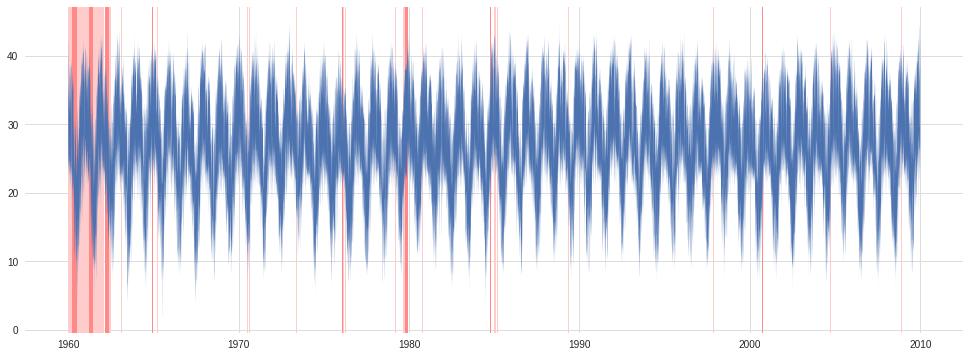

In [10]:
# You can adjust the visualisation range and dataset here.
# Interpolated regions of the dataset are marked in red.
WEATHER_STATION = 0 # 0 to 7 in default eval dataset
START_DATE = 0      # 0 = Jan 2nd 1950
END_DATE = MAX_DATE # 18262 = Dec 31st 2009
visu_temperatures = evtemps[WEATHER_STATION, START_DATE:END_DATE]
visu_dates        = evdates[WEATHER_STATION, START_DATE:END_DATE]
visu_interpolated = evinter[WEATHER_STATION, START_DATE:END_DATE]

picture_this_4(visu_temperatures, visu_dates, visu_interpolated)

## Resampling
In this playground notebook, resampling is initially set to RESAMPLE_BY=1 (no resampling).
This is what (Tmin, Tmax) temperatures look like.

In [0]:
# This time we ask the utility function to average temperatures over RESAMPLE_BY day periods (in days)
eval_dataset = rnn_dataset_sequencer3tfrec(eval_filenames, RESAMPLE_BY, seqlen=MAX_DATE//RESAMPLE_BY)
evaluation_data = dataset_to_numpy(eval_dataset)[0] # all data returned as one batch
evaltemps, _, evaldates, _ = evaluation_data

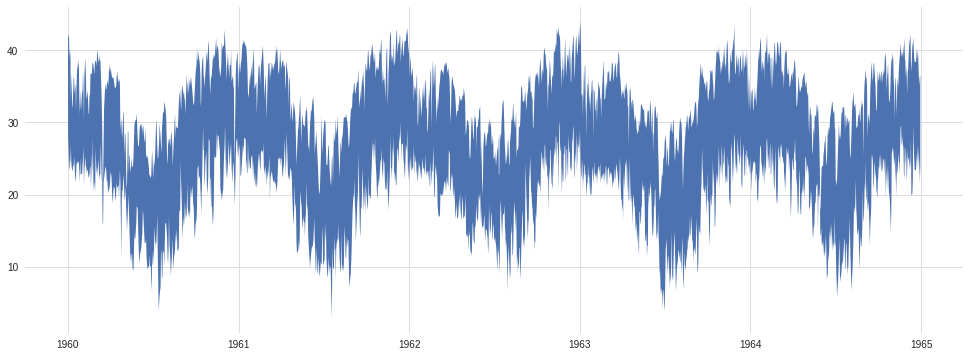

In [13]:
# display five years worth of data
WEATHER_STATION = 0              # 0 to 7 in default eval dataset
START_DATE = 0                   # 0 = Jan 2nd 1950
END_DATE = 365*5//RESAMPLE_BY    # 5 years
visu_temperatures = evaltemps[WEATHER_STATION, START_DATE:END_DATE]
visu_dates        = evaldates[WEATHER_STATION, START_DATE:END_DATE]
plt.fill_between(visu_dates, visu_temperatures[:,0], visu_temperatures[:,1])
plt.show()

## Visualize training sequences
This is what the neural network will see during training.

In [0]:
# The sequencing function puts one weather station per line in a batch and
# continues with data from the same station in corresponding lines in the next batch.
# Features and labels are returned with shapes [BATCHSIZE, SEQLEN, 2]

eval_dataset = rnn_dataset_sequencer3tfrec(eval_filenames,
                                           RESAMPLE_BY,
                                           BATCHSIZE,
                                           SEQLEN,
                                           N_FORWARD)

visu_data = dataset_to_numpy(eval_dataset, batches=6)

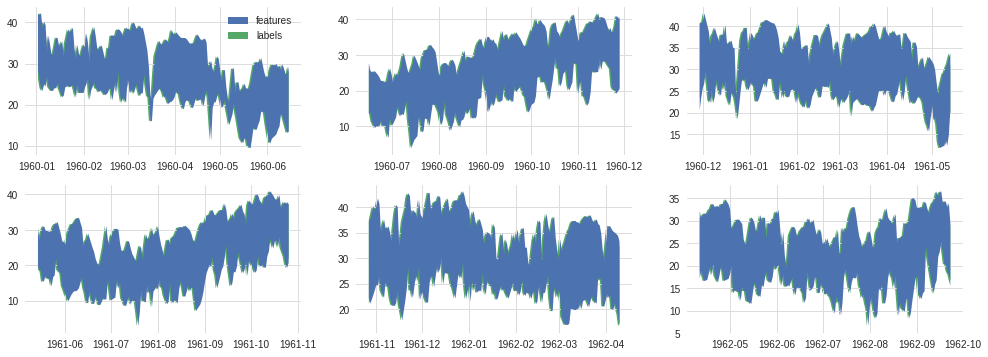

In [15]:
# Check that consecutive training sequences from the same weather station are indeed consecutive
WEATHER_STATION = 0
picture_this_5(visu_data, WEATHER_STATION)

## Keras model [WORK REQUIRED]
1. Run the notebook as it is with the dummy model. Check the temperature predictions in the Validation section. They are really bad of course.
1. Now implement a 2-layer RNN using stateful GRU cells.
 * The input and output shapes are both [batchsize, seqlen, 2]. The 2 is for (Tmin, Tmax). The model will be trained to output the same sequence shifted by one i.e. to predict the next value after the input sequence.
 * Do not forget to unroll the readout regression layer with tf.ketas.layers.TimeDistributed()
 * Check your shapes, yada yada yada <font size="+2">🤯</font>you know the drill now.
1. Try to train it using all 1666 weather stations for 4 epochs
 * On CPU the ETA is 2h... Stop the training.
 * (optional) Switch to a GPU backend (menu Runtime > Change Runtime Type). Re-execute the notebook from the begining. ETA=40min... Stop the training.
 * (optional) You can try GPU-optimized tf.keras.layers.CuDNNGRU cells. ETA=15min. Stop the training. Revert back to tf.keras.layers.GRU.
 * Switch to a TPU backend. ETA = 3m. This time, please wait.<br/>
 => The final RMSE is promising but the loss is really noisy and the predictions are horrible (and slow, stop after a couple)
1. The model is good, soemthing is wrong with the data. Look at the training sequences in the cell above. Think. You are a data scientist, you should be able to figure it out.
1. Daily temperatures fluctuate too much. Let's try to predict 5-day averages instead.
 * Set RESAMPLE_BY=5 in section "Hyperparameters"
 * Set NB_EPOCHS=8 in section "The training loop"
 * re-train from scratch (menu Runtime > "Restart all runtimes" to reset everything ).<br/>
  => Notice in section "Visualize training sequences" that a training sequence now spans multiple years. This should make it easier for the RNN to spot a pattern.<br/>
  => Look at predictions. They are starting to move but are still very far off.
1. Look at the data visualization above. The average temperature of the next 5 days is still very random. There is a trend but on a longer time frame. The trick is to train the RNN to predict the next 8 values instead of the next 1. This can be achieved by shifting the data by 8 instead of 1 when creating the targets. 8 five-day periods ahead, the temperature trend should be quite clear.
 * Set N_FORWARD=8 in section "Hyperparameters" and re-train from scratch<br/>
 => The predictions should now make sense even if they tend to drift off
1. GRU cells are cheap and usually good enough. For sensitive cases though, tf.keras.layers.LSTM cells can be more precise. Replace your GRU cells with LSTM cells and re-train. This should do the trick.
1. (optional) Stateful RNNs require training data in a precise order otherwise the RNN state between batches is wrong and training is disrupted. At least, that's the theory. Let's try to break the order of the training dataset and see what happens.
 * Locate the dataset() function below and modify it to return dataset.shuffle(20).<br/>
 This will shuffle the next 20 batches and break their careful ordering. Re-train.<br/>
 => The loss is noisier but predictions might still be OK.<br/>
 In practice, training with bad input states introduces noice at the begining of each sequence, but with sequences long enough, the impact can be small. Most data scientists do not bother with correct sequence ordering. It's hard. You can have a look at the code of the rnn_dataset_sequencer3tfrec function in the "utilities" section above. It is a bit complex.
![alt text](https://googlecloudplatform.github.io/tensorflow-without-a-phd/images/RNN2.svg)

In [0]:
def keras_model(batchsize, seqlen):
  l = tf.keras.layers  # syntax shortcut
  
  model = tf.keras.Sequential([
      # Instead of specifyting the input_shape and batch size on the first layer, you can have an InputLayer to hold these parameters.
      l.InputLayer(batch_size=batchsize, input_shape=[seqlen, 2]), # 2 for (Tmin, Tmax). Batch size is mandatory in Keras stateful RNN.
      
      #
      # YOUR LAYERS HERE
      #
      l.Lambda(lambda x: x) # dummy model
  ]) 
    
  # Tip: use  CuDNN optimized GRU cells on GPU
  # l.CuDNNGRU(RNN_CELLSIZE, stateful=True, return_sequences=True)
  
  def rmse(y_true, y_pred): # Root Mean Squared Error (Keras does not have a predefined metric for this)
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))
  
  model.compile(
      optimizer='rmsprop',
      loss='mean_squared_error',
      metrics=[rmse])

  return model

In [0]:
# Keras model callbacks

# This callback records a per-step loss history instead of the average loss per
# epoch that Keras normally reports. It allows you to see more problems.
class LossHistory(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
      self.history = {'loss': []}
  def on_batch_end(self, batch, logs={}):
      self.history['loss'].append(logs.get('loss'))

# Learning Rate decay absolutely necessary on this model
def lr_schedule(epoch): return 0.0001 + 0.01 * math.pow(0.6, epoch)
lr_decay = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)

## The training loop

Training a stateful RNN theoretically requires data from weather stations to be arranges into batches so that data from one weather station continues 
on the same line across all batches. This way, the RNN state resulting from one batch is the correct RNN state for the next batch. This is already done correctly by the rnn_dataset_sequencer3tfrec function below.
![alt text](https://googlecloudplatform.github.io/tensorflow-without-a-phd/images/batching.svg)

In [0]:
NB_EPOCHS = 4 # number of times the model sees all the data during training

# The model
model = keras_model(BATCHSIZE, SEQLEN)

# this prints a description of the model
model.summary()

display_lr(lr_schedule, NB_EPOCHS)

# The dataset
def dataset():
  dataset = rnn_dataset_sequencer3tfrec(train_filenames,
                                     RESAMPLE_BY,
                                     BATCHSIZE,
                                     SEQLEN,
                                     N_FORWARD,
                                     NB_EPOCHS,
                                     tminmax_only=True,
                                     drop_remainder=True) # necessary on TPU to ensure known tensor shapes
  return dataset.shuffle(20)

# TPU boilerplate code
if tpu:
  strategy = tf.contrib.tpu.TPUDistributionStrategy(tpu)
  model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)
else:                 # little wrinkle: Keras' model.fit works with a tf.data.Dataset
  dataset = dataset() # but on TPU, it must be a function returning a tf.data.Dataset.
  
# Training
steps_per_epoch = (nb_train_stations//BATCHSIZE) * (((MAX_DATE//RESAMPLE_BY)-(N_FORWARD))//SEQLEN)
full_history = LossHistory()
history = model.fit(dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=NB_EPOCHS,
                    callbacks=[lr_decay, full_history])

In [0]:
display_loss(history.history, full_history.history, NB_EPOCHS)

## Inference model

In [0]:
inference_model = keras_model(1, N_FORWARD)
inference_model.set_weights(model.get_weights())

In [0]:
# Inference from stateful model
def keras_prediction_run(model, prime_data, run_length):
  model.reset_states()
  
  data_len = prime_data.shape[0]
  
  Yin = prime_data[-(data_len//N_FORWARD)*N_FORWARD:]  # trim start of sequence to make length divisible by N_FORWARD
  Yin = np.reshape(Yin, [data_len//N_FORWARD, N_FORWARD, 2])
  
  # prime the state from data
  if data_len//N_FORWARD > 0:
    for i in range(data_len//N_FORWARD - 1): # keep last N_FORWARD samples to serve as the input sequence for predictions
      model.predict(np.expand_dims(Yin[i], axis=0))

    # prime predictions with real data: the last N_FORWARD samples
    Yout = np.expand_dims(Yin[data_len//N_FORWARD - 1], axis=0)
    # Yout shape [1, N_FORWARD, 2]: batch of a single sequence of length N_FORWARD of (Tmin, Tmax) data pointa
  
  # prediction run
  results = []
  for i in range(run_length//N_FORWARD+1):
    Yout = model.predict(Yout)
    results.append(Yout[0]) # shape [N_FORWARD, 2]

  return np.concatenate(results, axis=0)[:run_length]

## Validation

In [0]:
QYEAR = 365//(RESAMPLE_BY*4)
YEAR = 365//(RESAMPLE_BY)

# Try starting predictions from January / March / July (resp. OFFSET = YEAR or YEAR+QYEAR or YEAR+2*QYEAR)
# Some start dates are more challenging for the model than others.
OFFSET = 30*YEAR+1*QYEAR
PRIMELEN=5*YEAR
RUNLEN=3*YEAR
RMSELEN=3*365//(RESAMPLE_BY*2) # accuracy of predictions 1.5 years in advance

In [0]:
selected_evaluation_data = tuple(data[np.array([1, 2, 3, 4, 5, 6, 7, 12])] for data in evaluation_data) # selecting 8 interesting stations
eval_temps, _, eval_dates, _ = selected_evaluation_data
for temp_seq, date_seq in zip(eval_temps, eval_dates):
    prime_data = temp_seq[OFFSET:OFFSET+PRIMELEN]
    results = keras_prediction_run(inference_model, prime_data, RUNLEN)
    picture_this_6(temp_seq, date_seq, prime_data, results, PRIMELEN, RUNLEN, OFFSET, RMSELEN)

In [0]:
rmses = []
bad_ones = 0
eval_temps, _, eval_dates, _ = selected_evaluation_data # use evaluation_data for a more accurate eval
for offset in [YEAR, YEAR+QYEAR, YEAR+2*QYEAR]:
    for evaldata in eval_temps:
        prime_data = evaldata[offset:offset+PRIMELEN]
        results = keras_prediction_run(inference_model, prime_data, RUNLEN)
        rmse = math.sqrt(np.mean((evaldata[offset+PRIMELEN:offset+PRIMELEN+RMSELEN] - results[:RMSELEN])**2))
        rmses.append(rmse)
        if rmse>7: bad_ones += 1
        print("RMSE on {} predictions (shaded area): {}".format(RMSELEN, rmse))
print("Average RMSE on {} weather stations: {} ({} really bad ones, i.e. >7.0)".format(len(evaltemps), np.mean(rmses), bad_ones))

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
[http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.